In [79]:
%run _utils.ipynb

In [80]:
all_issues = load_all_issues()
gk_issues = all_issues[all_issues['user_login'] == 'greenkeeper[bot]']
gk_prs = gk_issues[gk_issues['is_pull_request']]
gk_issues = gk_issues[~gk_issues['is_pull_request']]

In [81]:
import requests
import json
url = 'https://raw.githubusercontent.com/greenkeeperio/monorepo-definitions/master/index.js'
resp = requests.get(url)
js = resp.text
json_text = js.split(' = ')[1]
json_text = json_text.replace('\'', '"')
json_text = json_text.replace('//', '')
json_text = json_text.split('module.exports')[0]
data = json.loads(json_text)
monorepos = data.keys()
print(monorepos)

dict_keys(['angular', 'angular2', 'angular1', 'apollo-client', 'apollo-link', 'apollo-server', 'apollo-tooling', 'aws-cdk', 'babel', 'babel7', 'baset', 'commitlint', 'electron-builder', 'emotion', 'enzyme', 'fortawesome', 'gatsby', 'jest', 'jest2', 'lodash', 'material-ui', 'nestjs', 'ngxs', 'polyfill-io-aot', 'pouchdb', 'react', 'react-dnd', 'storybook', 'react-cosmos', 'uppy', 'vue', 'gk-test', 'appcenter', 'material', 'pika-builders', 'reach-ui'])


## Looking at PRs

In [82]:
monorepo_pr_pattern = f'^Update ({"|".join(monorepos)}) to the latest version'
monorepo_pr_pattern

'^Update (angular|angular2|angular1|apollo-client|apollo-link|apollo-server|apollo-tooling|aws-cdk|babel|babel7|baset|commitlint|electron-builder|emotion|enzyme|fortawesome|gatsby|jest|jest2|lodash|material-ui|nestjs|ngxs|polyfill-io-aot|pouchdb|react|react-dnd|storybook|react-cosmos|uppy|vue|gk-test|appcenter|material|pika-builders|reach-ui) to the latest version'

In [83]:
prs_for_monorepos = gk_prs[gk_prs['title'].str.match(monorepo_pr_pattern)].copy()
prs_for_monorepos['type'] = 'monorepo'
prs_for_non_monorepos = gk_prs[~gk_prs['title'].str.match(monorepo_pr_pattern)].copy()
prs_for_non_monorepos['type'] = 'non_monorepo'

In [84]:
closed_prs_for_monorepos = prs_for_monorepos[~pd.isna(prs_for_monorepos['closed_at'])].copy()
closed_prs_for_monorepos['time_to_close'] = closed_prs_for_monorepos['closed_at'] - closed_prs_for_monorepos['created_at']
closed_prs_for_monorepos['time_to_close'].describe()

count                          7803
mean     27 days 22:49:39.909906446
std      84 days 00:54:11.006945041
min                 0 days 00:00:01
25%          0 days 06:27:26.500000
50%                 1 days 13:20:48
75%                14 days 03:08:06
max              1173 days 14:51:01
Name: time_to_close, dtype: object

In [61]:
closed_prs_for_non_monorepos = prs_for_non_monorepos[~pd.isna(prs_for_non_monorepos['closed_at'])].copy()
closed_prs_for_non_monorepos['time_to_close'] = closed_prs_for_non_monorepos['closed_at'] - closed_prs_for_non_monorepos['created_at']
closed_prs_for_non_monorepos['time_to_close'].describe()

count                        291701
mean     34 days 18:37:51.454074549
std      96 days 08:39:15.069942755
min                 0 days 00:00:00
25%                 0 days 04:06:47
50%                 1 days 17:38:35
75%                19 days 04:33:49
max              1404 days 03:01:17
Name: time_to_close, dtype: object

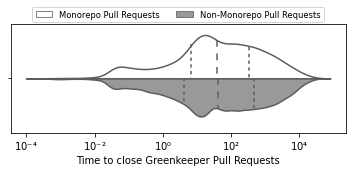

	Mann-Whitney: statistic=1131738629.0 pvalue=0.20126316747582318
	Cliff'a Delta: delta=-0.005544066036210418 size=negligible
    


In [72]:
cols = ['time_to_close', 'type']
for_plot = closed_prs_for_monorepos[cols].append(closed_prs_for_non_monorepos[cols])
for_plot['time_to_close_hours'] = for_plot['time_to_close'] / np.timedelta64(1, 'h')
for_plot = for_plot[for_plot['time_to_close_hours'] > 0]
for_plot['time_to_close_hours_log'] = np.log10(for_plot['time_to_close_hours'])
for_plot['placeholder'] = ''

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
sns.violinplot(
    data=for_plot,
    x='time_to_close_hours_log',
    y='placeholder',
    hue='type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Time to close Greenkeeper Pull Requests')
ax.xaxis.set_major_formatter(log10_func_formatter)

L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2,
    shadow=False,
)
L.get_texts()[0].set_text('Monorepo Pull Requests')
L.get_texts()[1].set_text('Non-Monorepo Pull Requests')

plt.show()

mannwhitneyu_cliffsdelta(
    for_plot[for_plot['type'] == 'monorepo']['time_to_close_hours'],
    for_plot[for_plot['type'] == 'non_monorepo']['time_to_close_hours']
)

## Looking at issues

In [52]:
gk_issues['title'].sample(10)

1244080    An in-range update of ember-frost-navigation is breaking the build 🚨
999404                  An in-range update of can-event is breaking the build 🚨
252929                     An in-range update of rollup is breaking the build 🚨
33401                       An in-range update of lerna is breaking the build 🚨
64892                  An in-range update of gulp-shell is breaking the build 🚨
451247                  An in-range update of puppeteer is breaking the build 🚨
2190219                     An in-range update of mocha is breaking the build 🚨
1797600                    An in-range update of babel7 is breaking the build 🚨
767218               An in-range update of @types/sinon is breaking the build 🚨
2207849           An in-range update of request-promise is breaking the build 🚨
Name: title, dtype: object

In [53]:
monorepo_issue_pattern = f'^An in-range update of ({"|".join(monorepos)}) is breaking the build'
monorepo_issue_pattern

'^An in-range update of (angular|angular2|angular1|apollo-client|apollo-link|apollo-server|apollo-tooling|aws-cdk|babel|babel7|baset|commitlint|electron-builder|emotion|enzyme|fortawesome|gatsby|jest|jest2|lodash|material-ui|nestjs|ngxs|polyfill-io-aot|pouchdb|react|react-dnd|storybook|react-cosmos|uppy|vue|gk-test|appcenter|material|pika-builders|reach-ui) is breaking the build'

In [75]:
issues_for_monorepos = gk_issues[gk_issues['title'].str.match(monorepo_issue_pattern)].copy()
issues_for_monorepos['type'] = 'monorepo'
issues_for_non_monorepos = gk_issues[~gk_issues['title'].str.match(monorepo_issue_pattern)].copy()
issues_for_non_monorepos['type'] = 'non_monorepo'

In [76]:
closed_issues_for_monorepos = issues_for_monorepos[~pd.isna(issues_for_monorepos['closed_at'])].copy()
closed_issues_for_monorepos['time_to_close'] = closed_issues_for_monorepos['closed_at'] - closed_issues_for_monorepos['created_at']
closed_issues_for_monorepos['time_to_close'].describe()

count                           5789
mean      60 days 09:48:44.367593713
std      116 days 21:48:46.997651530
min                  0 days 00:00:10
25%                  0 days 20:22:15
50%                 10 days 03:42:36
75%                 61 days 23:56:53
max               1219 days 02:01:10
Name: time_to_close, dtype: object

In [77]:
closed_issues_for_non_monorepos = issues_for_non_monorepos[~pd.isna(issues_for_non_monorepos['closed_at'])].copy()
closed_issues_for_non_monorepos['time_to_close'] = closed_issues_for_non_monorepos['closed_at'] - closed_issues_for_non_monorepos['created_at']
closed_issues_for_non_monorepos['time_to_close'].describe()

count                          88252
mean      49 days 22:56:19.147690703
std      119 days 10:43:53.758122378
min                  0 days 00:00:04
25%                  0 days 08:02:34
50%                  4 days 03:07:56
75%          36 days 13:19:10.750000
max               1450 days 16:01:20
Name: time_to_close, dtype: object

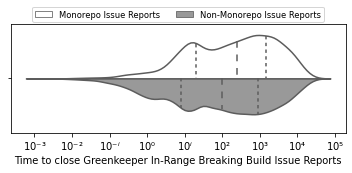

	Mann-Whitney: statistic=215470811.5 pvalue=4.287976817135657e-89
	Cliff'a Delta: delta=0.15648980294474968 size=small
    


In [78]:
cols = ['time_to_close', 'type']
for_plot = closed_issues_for_monorepos[cols].append(closed_issues_for_non_monorepos[cols])
for_plot['time_to_close_hours'] = for_plot['time_to_close'] / np.timedelta64(1, 'h')
for_plot = for_plot[for_plot['time_to_close_hours'] > 0]
for_plot['time_to_close_hours_log'] = np.log10(for_plot['time_to_close_hours'])
for_plot['placeholder'] = ''

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
sns.violinplot(
    data=for_plot,
    x='time_to_close_hours_log',
    y='placeholder',
    hue='type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Time to close Greenkeeper In-Range Breaking Build Issue Reports')
ax.xaxis.set_major_formatter(log10_func_formatter)

L = plt.legend(
    loc='upper center',
    fontsize='small',
    fancybox=True,
    bbox_to_anchor=(0.5,1.2),
    ncol=2,
    shadow=False,
)
L.get_texts()[0].set_text('Monorepo Issue Reports')
L.get_texts()[1].set_text('Non-Monorepo Issue Reports')

plt.show()

mannwhitneyu_cliffsdelta(
    for_plot[for_plot['type'] == 'monorepo']['time_to_close_hours'],
    for_plot[for_plot['type'] == 'non_monorepo']['time_to_close_hours']
)